In [1]:
%matplotlib notebook
import cv2
import numpy as np
from localBlur.likematlab import im2col, EM_GMM, GenerateF
import matplotlib.pyplot as plt
from scipy import stats

### 이미지를 흑백으로 변환

In [2]:
img = cv2.imread('../image/out_of_focus0015.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.normalize(img.astype('double'), None, 0.0, 1.0, cv2.NORM_MINMAX)
patchsize = 11

### localBlurScore 부분

In [3]:
im_height, im_width = img.shape
offset = int((patchsize -1)/2)
x_start = offset+1; x_end = im_width-offset;
y_start = offset+1; y_end = im_height-offset;
datasize = (x_end-x_start+1)*(y_end-y_start+1)

### LocalPowerSpectrumSlope

In [54]:
[If, IC] = GenerateF(offset,offset)
IC_log = np.log(IC)
IC_log_new = np.unique(np.round(IC_log / 0.2)*0.2)

In [56]:
im_col = im2col(img, [patchsize,patchsize])
im_col = im_col / np.sum(im_col,0,keepdims=True)
q = np.zeros((1,im_col.shape[1]))

### MATLAB 코드 
parfor i = 1:size(im_col,2)
    lsf = GenerateSf(reshape(im_col(:,i), [patchsize, patchsize]), lf, lC, offset, offset);
    lsf_new = rearrange(lC_log, lC_log_new, lsf);
    lsf_new = log(lsf_new(1:end-1));
    idx = ~(isnan(lsf_new) + isinf(lsf_new));   
    alf_local = sum(lsf_new(idx))
    q(i) = alf_local;
end

In [69]:
for i in range(im_col.shape[1]):
    lsf = GenerateSf(im_col[:,i].reshape(patchsize,patchsize), If, IC, offset, offset)
    lsf_new = rearrange(IC_log, IC_log_new, lsf)
    lsf_new = np.log(lsf_new[0:-1])
    idx = ~(np.isnan(lsf_new) + np.isinf(lsf_new))
    alf_local = np.sum(lsf_new[idx])
    q[0,i] = alf_local

C:\Users\sangjaekang123\Anaconda3\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: divide by zero encountered in log


In [70]:
q = q.reshape(im_width-patchsize+1,im_height-patchsize+1)
q = np.pad(q,offset,'edge')
q = np.transpose(q)

<IPython.core.display.Javascript object>


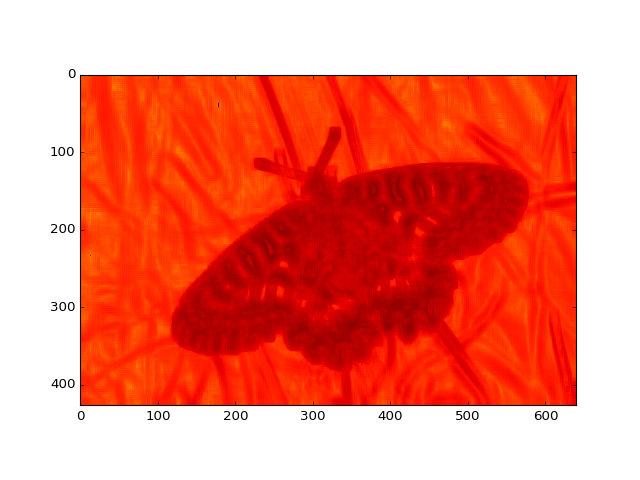

In [71]:
plt.imshow(q)

In [59]:
def calculateSf(s, C, f):
    sf = np.zeros(C.shape)
    for i in range(np.size(C)):
        sf[i] = np.sum(s[f==C[i]])
    return sf

In [60]:
def GenerateSf(im, f, C, half_height, half_width):
    height, width = im.shape
    s = np.abs(np.fft.fft2(im))
    s = np.square(s[0:half_height,0:half_width]) / (half_height * half_width)
    sf = calculateSf(s, C, f)
    return sf

In [61]:
def rearrange(C, C_new, f):
    data = np.zeros(C_new.shape)
    idx = 0 
    for i in range(len(f)):
        if (C[i] >= C_new[idx+1]):
            idx = idx+1
        data[idx] = data[idx] + f[i]        
    return data